## 1 - Instalando e carregando as bibliotecas necessárias

In [90]:
!pip install scikit-learn

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [91]:
!pip install boruta

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [92]:
!pip install lightgbm

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [93]:
!pip install xgboost

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [94]:
import numpy as np 
import pandas as pd 
import os
import time
import seaborn as sns
from seaborn import countplot,lineplot, barplot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import accuracy_score , f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import joblib


## 2 - Estudo das bases de dados

In [95]:
# Carregando o arquivo 'X_train.csv' que contém os dados de treinamento das variáveis independentes (features)
x_train = pd.read_csv('X_train.csv')

# Carregando o arquivo 'sample_submission.csv', que serve como exemplo de submissão e contém os ids ou rótulos esperados
sample_sub = pd.read_csv('sample_submission.csv')

# Carregando o arquivo 'X_test.csv', que contém os dados de teste (variáveis independentes) para a previsão
x_test = pd.read_csv('X_test.csv')

# Carregando o arquivo 'y_train.csv', que contém os rótulos (variáveis dependentes ou alvos) para o treinamento do modelo
y_train = pd.read_csv('y_train.csv')


In [96]:

# Função que verifica valores nulos 
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [97]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [98]:
y_train.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


In [99]:
# Aplicando função que aponta valores nulos.
missing_data(y_train)

,series_id,group_id,surface
Total,0,0,0
Percent,0.0,0.0,0.0
Types,int64,int64,object


In [100]:
# Verifica quantidade distintas da variavel alvo
surface=len(y_train["surface"].unique())
surface

9

c:\Users\Luno Fercrantz\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


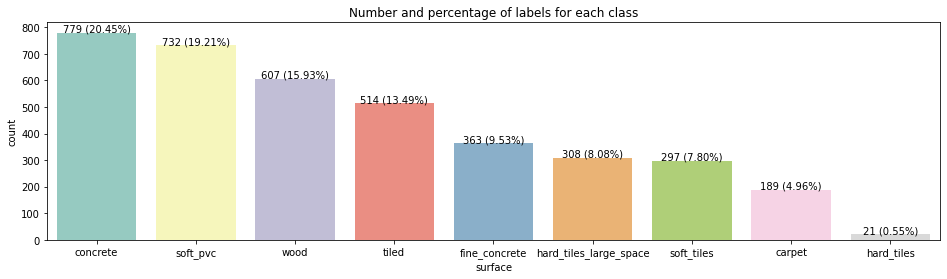

In [101]:
# Tamanho da figura
f, ax = plt.subplots(1, 1, figsize=(16, 4))

# Total de registros
total = float(len(y_train))

# Plot do gráfico de barras
g = sns.countplot(y_train['surface'], order=y_train['surface'].value_counts().index, palette='Set3')

# Título do gráfico
g.set_title("Number and percentage of labels for each class")

# Adicionando os números e percentuais acima de cada barra
for p in ax.patches:
    height = p.get_height()  # Altura da barra
    label = '{:1.0f} ({:1.2f}%)'.format(height, 100 * height / total)  # Texto com número e percentual
    ax.text(p.get_x() + p.get_width() / 2., height + 3, label, ha="center")  # Posiciona o texto

# Exibe o gráfico
plt.show()   

In [102]:
# Unificando os dataframes
df = pd.concat([x_train, x_test], ignore_index=True)
df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [103]:
df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000,976128.000000
mean,1906.001180,63.500000,0.006993,0.097875,0.015599,0.000113,0.000289,0.011005,-0.027649,0.127356,2.896536,-9.362346
std,1100.720858,36.949309,0.679326,0.711748,0.107281,0.102715,0.116134,0.089099,0.231640,1.851702,2.117524,2.824069
min,0.000000,0.000000,-0.989720,-0.989810,-0.162830,-0.156620,-2.403300,-1.193000,-1.458200,-36.067000,-121.490000,-83.173000
25%,953.000000,31.750000,-0.686040,-0.702790,-0.100980,-0.101550,-0.039035,-0.031492,-0.090310,-0.507410,2.007500,-10.158000
50%,1906.000000,63.500000,0.006222,0.336345,0.051583,0.005977,0.000585,0.006324,-0.007144,0.118970,2.889400,-9.363600
75%,2859.000000,95.250000,0.615560,0.804290,0.124150,0.087024,0.039166,0.049507,0.061186,0.759240,3.777500,-8.553300
max,3815.000000,127.000000,0.989320,0.988980,0.155710,0.154770,3.396600,1.150700,1.387300,36.797000,73.008000,65.839000


In [104]:
missing_data(df)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [105]:
# Fazendo o join baseado na coluna 'id'
df_total = pd.merge(df, y_train, on='series_id', how='inner')
df_total.drop(['group_id',"series_id"], axis=1, inplace=True)
missing_data(df_total)

,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,surface
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object


## Conclusão: Estudo das bases de dados

#### Superfície de Concreto: A base de dados contém uma quantidade maior de registros relacionados ao robô se movendo sobre superfícies de concreto.

#### Dados Não Classificados: Na base de teste, foram identificados pouco mais de 700 valores de superfícies sem classificação. Esses dados foram desconsiderados para evitar distorções na análise.

#### Integração das Bases: Optou-se por combinar as bases de treino e teste, visando uma avaliação mais precisa e sem viés.

#### Objetivo da Integração: A junção das bases possibilitou uma análise mais completa e robusta, garantindo maior precisão nas etapas posteriores da análise.


## 3 - Seleção de Variaveis (feature selection)

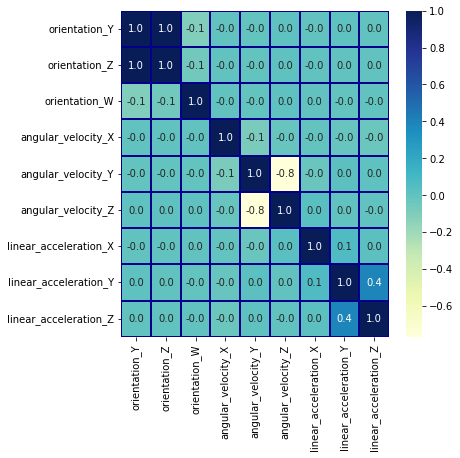

In [106]:

# Criando a visualização da matriz de correlação
f, ax = plt.subplots(figsize=(6, 6))
m = df_total.iloc[:, 3:].corr()  # Calcula a correlação entre as variáveis a partir da 4ª coluna
sns.heatmap(m, annot=True, linecolor='darkblue', linewidths=.1, cmap="YlGnBu", fmt='.1f', ax=ax)  # Exibe a matriz

# Definindo um limiar de correlação alta (0.7)
threshold = 0.7

# Filtrando as correlações acima de 0.7, excluindo as correlações de uma variável consigo mesma
high_corr = m[(m.abs() > threshold) & (m != 1.0)]

# Transformando os resultados em um DataFrame legível
high_corr_pairs = high_corr.dropna(how='all').stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']  # Renomeando as colunas



#### Esta seção faz um uso significativo do trabalho presente no seguinte Kernel: https://www.kaggle.com/code/gpreda/robots-need-help. O procedimento de transformação de quaternion_to_euler também é creditado no Kernel original, e mantive essa referência.

In [107]:

# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [108]:
def perform_euler_factors_calculation(df):
    df['total_angular_velocity'] = np.sqrt(np.square(df['angular_velocity_X']) + np.square(df['angular_velocity_Y']) + np.square(df['angular_velocity_Z']))
    df['total_linear_acceleration'] = np.sqrt(np.square(df['linear_acceleration_X']) + np.square(df['linear_acceleration_Y']) + np.square(df['linear_acceleration_Z']))
    df['total_xyz'] = np.sqrt(np.square(df['orientation_X']) + np.square(df['orientation_Y']) +
                              np.square(df['orientation_Z']))
    df['acc_vs_vel'] = df['total_linear_acceleration'] / df['total_angular_velocity']
    
    x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    df['euler_x'] = nx
    df['euler_y'] = ny
    df['euler_z'] = nz
    
    df['total_angle'] = np.sqrt(np.square(df['euler_x']) + np.square(df['euler_y']) + np.square(df['euler_z']))
    df['angle_vs_acc'] = df['total_angle'] / df['total_linear_acceleration']
    df['angle_vs_vel'] = df['total_angle'] / df['total_angular_velocity']
    return df

In [109]:
def perform_feature_engineering(df):
    df_out = pd.DataFrame()
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def mean_abs_change(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in df.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        df_out[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        df_out[col + '_min'] = df.groupby(['series_id'])[col].min()
        df_out[col + '_max'] = df.groupby(['series_id'])[col].max()
        df_out[col + '_std'] = df.groupby(['series_id'])[col].std()
        df_out[col + '_mad'] = df.groupby(['series_id'])[col].mad()
        df_out[col + '_med'] = df.groupby(['series_id'])[col].median()
        df_out[col + '_skew'] = df.groupby(['series_id'])[col].skew()
        df_out[col + '_range'] = df_out[col + '_max'] - df_out[col + '_min']
        df_out[col + '_max_to_min'] = df_out[col + '_max'] / df_out[col + '_min']
        df_out[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
        df_out[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df_out[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        df_out[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        df_out[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
        df_out[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))
        df_out[col + '_abs_avg'] = (df_out[col + '_abs_min'] + df_out[col + '_abs_max'])/2
        df_out[col + '_abs_range'] = df_out[col + '_abs_max'] - df_out[col + '_abs_min']

    return df_out

In [110]:
df_total_euler= perform_euler_factors_calculation(df_total)
df_total_euler.head()

,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,...,total_angular_velocity,total_linear_acceleration,total_xyz,acc_vs_vel,euler_x,euler_y,euler_z,total_angle,angle_vs_acc,angle_vs_vel
0,0_0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,...,0.109076,10.005392,0.994368,91.728917,2.843272,-0.024668,1.396664,3.167882,0.316617,29.042977
1,0_1,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,...,0.074240,9.538638,0.994364,128.483970,2.843199,-0.024662,1.396646,3.167808,0.332103,42.669888
2,0_2,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,...,0.030428,8.874697,0.994372,291.666195,2.843224,-0.024728,1.396682,3.167847,0.356953,104.111031
3,0_3,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,...,0.025082,10.164638,0.994374,405.249042,2.843186,-0.024770,1.396721,3.167830,0.311652,126.296697
4,0_4,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,...,0.010603,10.556132,0.994368,995.561076,2.843195,-0.024784,1.396693,3.167826,0.300093,298.761364


In [111]:
correlations = df_total_euler.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
# Definindo um limite de correlação alta (exemplo: 0.8)
limite_corr = 0.9

# Filtrando as correlações para manter apenas as de valor absoluto maior que o limite
correlations_high = correlations[correlations[0] >= limite_corr]

# Exibindo o DataFrame com as correlações altas
correlations_high

,level_0,level_1,0
412,total_angle,total_xyz,0.963514
413,total_xyz,total_angle,0.963514
414,acc_vs_vel,angle_vs_vel,0.989328
415,angle_vs_vel,acc_vs_vel,0.989328
416,orientation_Y,orientation_Z,0.998159
417,orientation_Z,orientation_Y,0.998159
418,orientation_W,orientation_X,0.998475
419,orientation_X,orientation_W,0.998475


In [112]:
# Definindo as variáveis independentes (X) e a variável alvo (y)

# Removendo a coluna 'ID', pois ela não é informativa para o modelo
df_qui = df_total_euler.drop(columns=['row_id'])

X = df_qui.drop(columns=['surface'])
y = df_qui['surface']

# Codificando as variáveis alvo (target) numéricamente
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Aplicando Min-Max scaling nas variáveis independentes (features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando o teste qui-quadrado
chi2_values, p_values = chi2(X_scaled, y_encoded)

# Criando um DataFrame para exibir os resultados
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi-Squared Statistic': chi2_values,
    'p-value': p_values
})

# Exibindo os resultados
print(chi2_results)


                      Feature  Chi-Squared Statistic        p-value
0          measurement_number           1.482659e-26   1.000000e+00
1               orientation_X           1.011082e+04   0.000000e+00
2               orientation_Y           1.673693e+03   0.000000e+00
3               orientation_Z           1.263993e+03  1.423699e-267
4               orientation_W           9.215878e+03   0.000000e+00
5          angular_velocity_X           1.012582e-02   1.000000e+00
6          angular_velocity_Y           2.286432e+01   3.542886e-03
7          angular_velocity_Z           1.642884e+02   2.026581e-31
8       linear_acceleration_X           8.382182e-02   9.999999e-01
9       linear_acceleration_Y           2.025840e-02   1.000000e+00
10      linear_acceleration_Z           3.792597e-03   1.000000e+00
11     total_angular_velocity           1.612074e+03   0.000000e+00
12  total_linear_acceleration           1.903521e+01   1.467246e-02
13                  total_xyz           1.162877

## Variáveis Significativas e Não Significativas

A partir dos resultados do teste qui-quadrado, podemos identificar as variáveis significativas e não significativas com base no valor p (p-value).

### Variáveis Significativas
As variáveis com p-valor muito baixo (geralmente menor que 0.05) indicam uma relação estatisticamente significativa com a variável de destino. As variáveis significativas incluem:

- **orientation_X** (p-value = 0.000000e+00)
- **orientation_Y** (p-value = 0.000000e+00)
- **orientation_Z** (p-value = 1.423699e-267)
- **orientation_W** (p-value = 0.000000e+00)
- **angular_velocity_Y** (p-value = 3.542886e-03)
- **angular_velocity_Z** (p-value = 2.026581e-31)
- **total_angular_velocity** (p-value = 0.000000e+00)
- **total_linear_acceleration** (p-value = 1.467246e-02)
- **total_xyz** (p-value = 1.004848e-245)
- **acc_vs_vel** (p-value = 6.858011e-42)
- **euler_x** (p-value = 1.582156e-82)
- **euler_y** (p-value = 1.371055e-37)
- **euler_z** (p-value = 0.000000e+00)
- **total_angle** (p-value = 0.000000e+00)
- **angle_vs_vel** (p-value = 1.162812e-41)

### Variáveis Não Significativas
As variáveis com p-valores próximos de 1 (geralmente maiores que 0.05) indicam uma relação não significativa com a variável de destino. As variáveis não significativas incluem:

- **measurement_number** (p-value = 1.000000e+00)
- **angular_velocity_X** (p-value = 1.000000e+00)
- **linear_acceleration_X** (p-value = 9.999999e-01)
- **linear_acceleration_Y** (p-value = 1.000000e+00)
- **linear_acceleration_Z** (p-value = 1.000000e+00)
- **angle_vs_acc** (p-value = 8.761232e-02)

Portanto, as variáveis mais significativas para o modelo incluem aquelas relacionadas às orientações (X, Y, Z, W), velocidades angulares, aceleração linear e ângulos, enquanto as variáveis como número de medição e acelerações lineares em X, Y, Z não mostram uma relação forte com a variável de destino.





## 4 - Aplicação dos modelos: 
#### Não foram utilizadas variáveis com alta correlação ou aquelas que não apresentaram significância.

In [113]:
from sklearn.tree import DecisionTreeClassifier

# Removendo a coluna 'ID', pois ela não é informativa para o modelo
df_lbg = df_total_euler.drop(columns=['row_id',
                                      "measurement_number",
                                      "angular_velocity_X",
                                      "linear_acceleration_X",
                                      "linear_acceleration_Y",
                                      "linear_acceleration_Z",
                                      "angle_vs_acc",
                                      "total_xyz",
                                      "acc_vs_vel",
                                      "angle_vs_vel",
                                      "orientation_Z",
                                      "orientation_X"])

# Definindo as variáveis independentes (X) e a variável alvo (y)
X = df_lbg.drop(columns=['surface'])
y = df_lbg['surface']

# Codificando as variáveis alvo (target) numéricamente
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalizando as features usando Min-Max Scaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.5, random_state=42)

# Criando o modelo de Árvore de Decisão
model_dt = DecisionTreeClassifier(random_state=42)

# Treinando o modelo
model_dt.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model_dt.predict(X_test)

# Avaliando a acurácia no conjunto de teste
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo no conjunto de teste: {accuracy_test * 100:.2f}%")

# Avaliando a acurácia no conjunto de treinamento
y_train_pred = model_dt.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Acurácia do modelo no conjunto de treinamento: {accuracy_train * 100:.2f}%")

# Calculando o F1-Score (usando a média ponderada para múltiplas classes)
f1_test = f1_score(y_test, y_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')
print(f"F1-Score no conjunto de teste: {f1_test:.2f}")
print(f"F1-Score no conjunto de treinamento: {f1_train:.2f}")




Acurácia do modelo no conjunto de teste: 88.41%
Acurácia do modelo no conjunto de treinamento: 100.00%
F1-Score no conjunto de teste: 0.88
F1-Score no conjunto de treinamento: 1.00


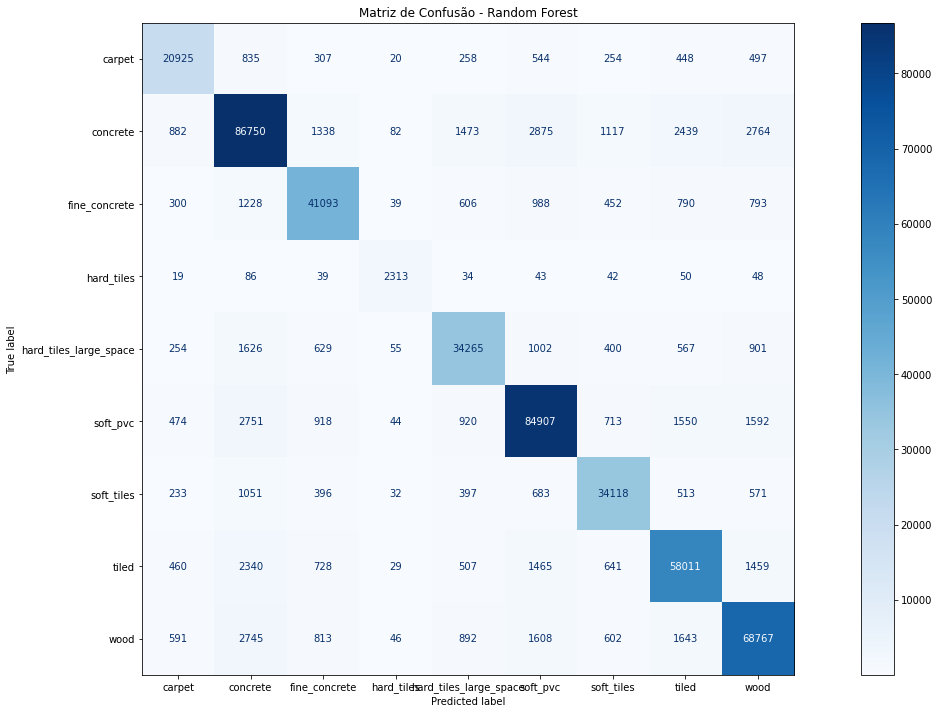

In [114]:
# Decodificando as variáveis alvo de volta para as categorias originais
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Gerando a matriz de confusão
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Criando uma figura maior para o gráfico
fig, ax = plt.subplots(figsize=(24, 12))  # Ajuste o tamanho da figura conforme necessário

# Plotando a matriz de confusão
disp.plot(cmap='Blues', ax=ax)

# Adicionando título ao gráfico
plt.title("Matriz de Confusão - Random Forest")

# Exibindo o gráfico
plt.show()



In [115]:
# Removendo a coluna 'ID', pois ela não é informativa para o modelo
df_lbg = df_total_euler.drop(columns=['row_id',
                                      "measurement_number",
                                      "angular_velocity_X",
                                      "linear_acceleration_X",
                                      "linear_acceleration_Y",
                                      "linear_acceleration_Z",
                                      "angle_vs_acc",
                                      "total_xyz",
                                      "acc_vs_vel",
                                      "angle_vs_vel",
                                      "orientation_Z",
                                      "orientation_X"])

# Definindo as variáveis independentes (X) e a variável alvo (y)
X = df_lbg.drop(columns=['surface'])
y = df_lbg['surface']

# Codificando as variáveis alvo (target) numéricamente
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalizando as features usando Min-Max Scaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)


model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',  # Função objetivo para classificação multiclasse
    num_class=len(label_encoder.classes_),  # Número de classes no problema
    learning_rate=0.05,  # Taxa de aprendizado
    n_estimators=500,  # Número de árvores
    max_depth=10,
    min_child_weight=1,  # Peso mínimo de uma folha
    subsample=0.8,  # Subamostragem dos dados para cada árvore
    colsample_bytree=0.8,  # Subamostragem das features para cada árvore
    gamma=0,  # Redução mínima da perda para divisão de nó
    random_state=42  # Para reprodutibilidade  # Profundidade máxima das árvores

)


# Treinando o modelo
model_xgb.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model_xgb.predict(X_test)

# Avaliando a acurácia no conjunto de teste
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo no conjunto de teste: {accuracy_test * 100:.2f}%")

# Avaliando a acurácia no conjunto de treinamento
y_train_pred = model_xgb.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Acurácia do modelo no conjunto de treinamento: {accuracy_train * 100:.2f}%")

# Calculando o F1-Score (usando a média ponderada para múltiplas classes)
f1_test = f1_score(y_test, y_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')
print(f"F1-Score no conjunto de teste: {f1_test:.2f}")
print(f"F1-Score no conjunto de treinamento: {f1_train:.2f}")
print(f"Previsões: {y_pred_labels}")


Acurácia do modelo no conjunto de teste: 90.70%
Acurácia do modelo no conjunto de treinamento: 94.59%
F1-Score no conjunto de teste: 0.91
F1-Score no conjunto de treinamento: 0.95
Previsões: ['wood' 'soft_pvc' 'wood' ... 'soft_pvc' 'wood' 'soft_tiles']


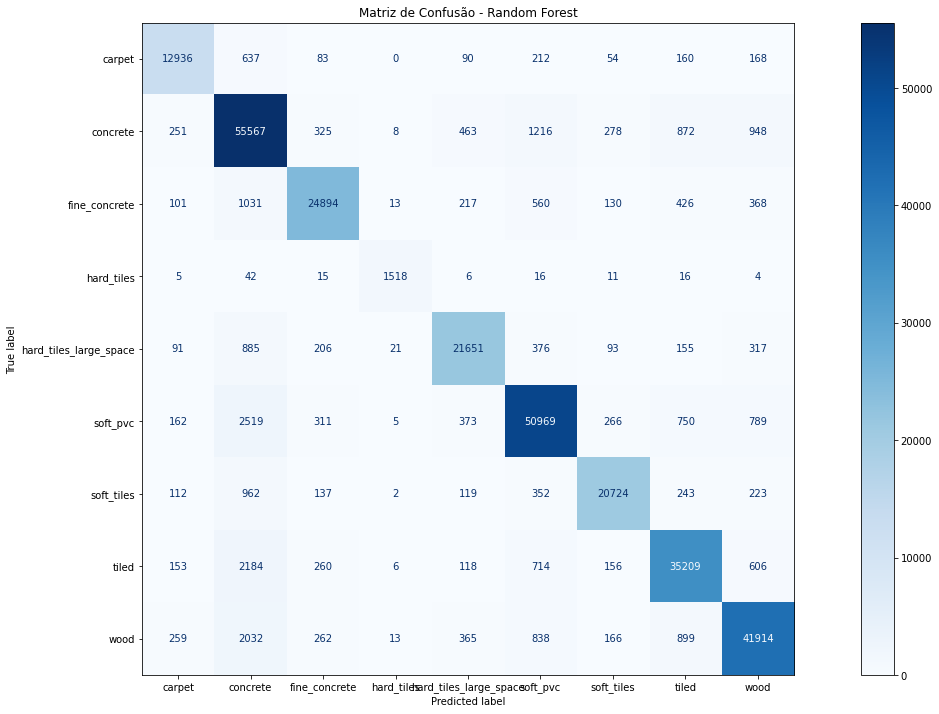

In [116]:
# Decodificando as variáveis alvo de volta para as categorias originais
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Gerando a matriz de confusão
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Criando uma figura maior para o gráfico
fig, ax = plt.subplots(figsize=(24, 12))  # Ajuste o tamanho da figura conforme necessário

# Plotando a matriz de confusão
disp.plot(cmap='Blues', ax=ax)

# Adicionando título ao gráfico
plt.title("Matriz de Confusão - Random Forest")

# Exibindo o gráfico
plt.show()

In [118]:
# Salvando o modelo treinado
joblib.dump(model_xgb, 'model_gb.pkl')

# Salvando o scaler
joblib.dump(scaler, 'scaler.pkl')

# Salvando o label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

## Conclusão: Aplicação dos modelos
#### O modelo selecionado foi o XGBoost, pois apresentou a melhor acurácia e F1-Score. Além disso, não há indícios de overfitting ou underfitting, uma vez que a acurácia de treinamento (94%) é próxima da acurácia de teste (91%).